In [10]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 43.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 73.0 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 114.2 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=d22b248f9a43ef208671a7b401e264c92d3526cdcd7184682c1f67691fc8ddae
  Stored in directory: /home/ec2-user/.cache/pip/wheels/9b/0a/31/eb0e590d74ec13e90493cb6d1cd92a379a1a3b8f12ed778a14
Successfully built pymeeus


In [126]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [127]:
df = pd.read_csv("data.csv", index_col=0)
df = df.fillna(0) # replace nulls with zeros in sales and orders
df = df.drop_duplicates()

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 939 entries, 0 to 1876
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     939 non-null    object 
 1   item_number             939 non-null    int64  
 2   item_name               939 non-null    object 
 3   purchase_price          939 non-null    float64
 4   suggested_retail_price  939 non-null    float64
 5   orders_quantity         939 non-null    float64
 6   sales_quantity          939 non-null    float64
 7   revenue                 939 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 66.0+ KB


In [112]:
items = df['item_number'].unique()

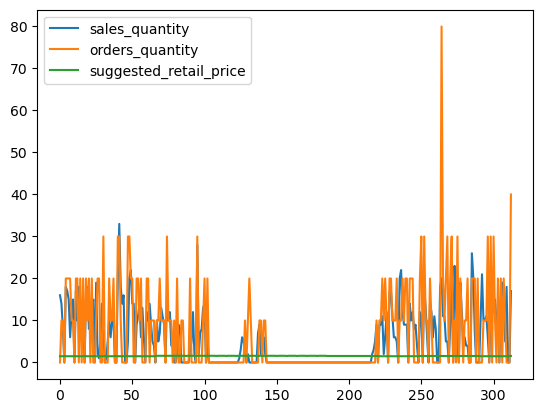

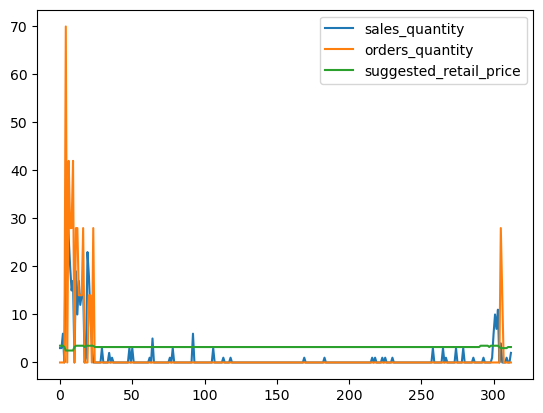

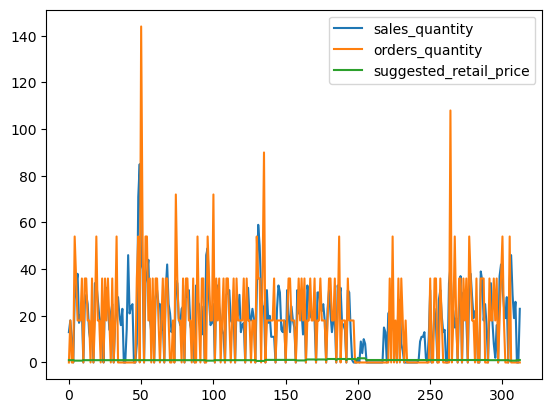

In [121]:
for i in items:
    df_item = df[df['item_number']==i]
    x = df_item['day'].values
    sales_quantity = df_item['sales_quantity'].values
    orders_quantity = df_item['orders_quantity'].values
    pyplot.plot(sales_quantity, label='sales_quantity')
    pyplot.plot(orders_quantity, label='orders_quantity')
#     pyplot.plot()
    pyplot.legend()
    pyplot.show()
    

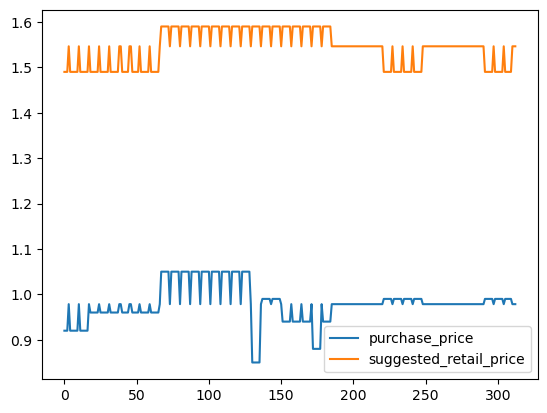

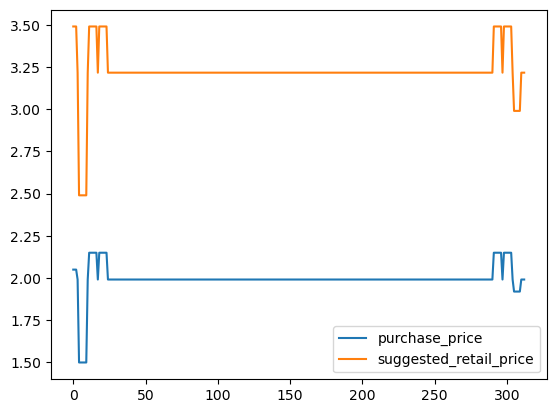

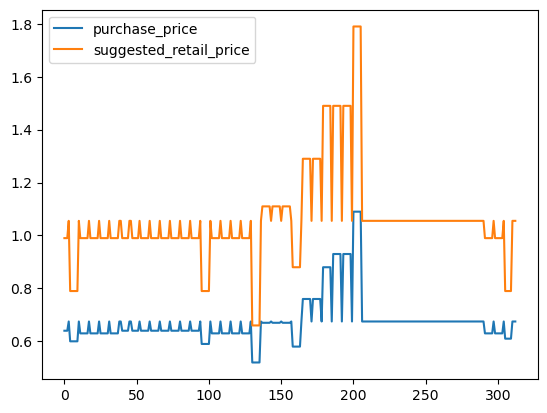

In [122]:
"""analysying purchase & retail price"""
for i in items:
    df_item = df[df['item_number']==i]
    x = df_item['day'].values
    pyplot.plot(df_item['purchase_price'].values, label='purchase_price')
    pyplot.plot(df_item['suggested_retail_price'].values, label='suggested_retail_price')
#     pyplot.plot()
    pyplot.legend()
    pyplot.show()

# Experiment 1

In [97]:
exp_date ='2022-01-01'
def train_prophet(df_item):
    df_item = df_item.rename(columns={
        'day':'ds',
        'sales_quantity': 'y'
    })
    
    model = Prophet(interval_width=0.95)
    
    ts_train = (df_item.query(f"ds < '{exp_date}'")
                  .sort_values('ds')
                )

    ts_test = (df_item
               .query(f"ds >= '{exp_date}'")
               .sort_values('ds')
               .assign(ds=lambda x: pd.to_datetime(x["ds"]))
               )
    model.fit(ts_train)

  
    # at this step we predict the future and we get plenty of additional columns be cautious
    ts_hat = (model.predict(ts_test)[["ds", "yhat", 'yhat_lower', 'yhat_upper']]
              .assign(ds=lambda x: pd.to_datetime(x["ds"]))
              ).merge(ts_test, on=["ds"], how="left")  # merge to retrieve item and store index
    
    model.plot(ts_hat)
 
    return ts_hat

18:08:07 - cmdstanpy - INFO - Chain [1] start processing
18:08:07 - cmdstanpy - INFO - Chain [1] done processing
18:08:07 - cmdstanpy - INFO - Chain [1] start processing
18:08:07 - cmdstanpy - INFO - Chain [1] done processing
18:08:08 - cmdstanpy - INFO - Chain [1] start processing
18:08:08 - cmdstanpy - INFO - Chain [1] done processing


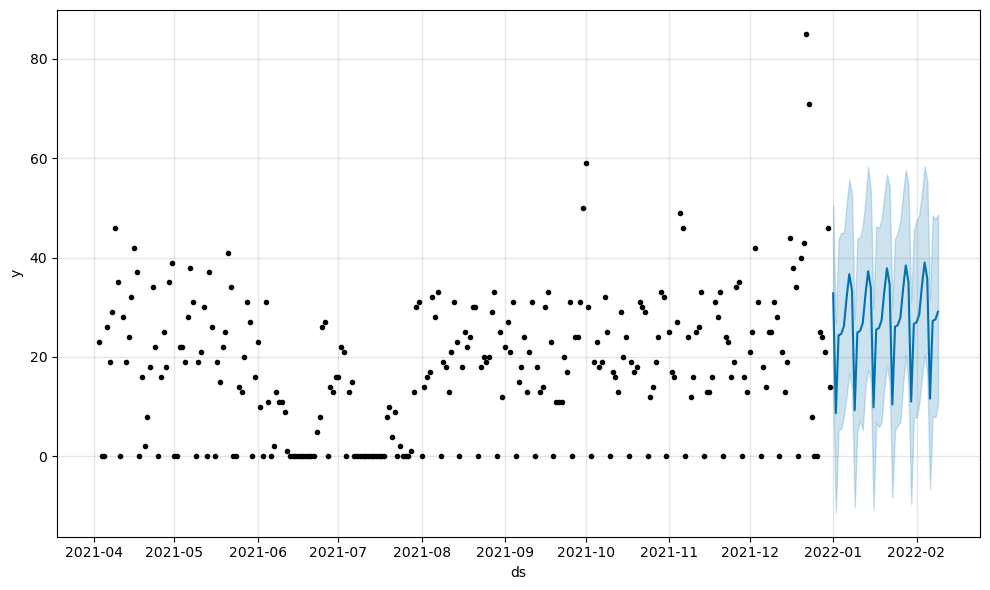

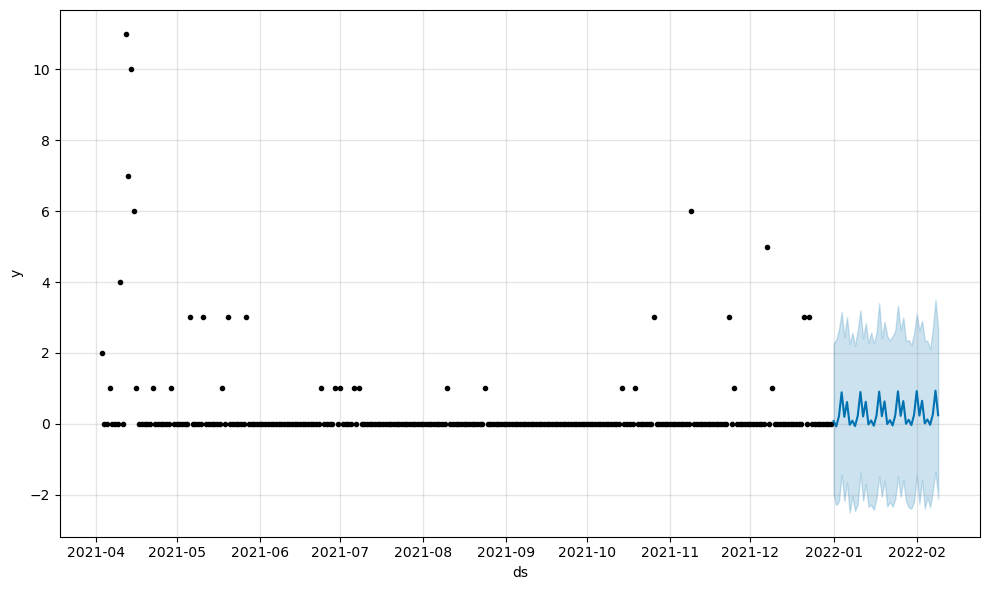

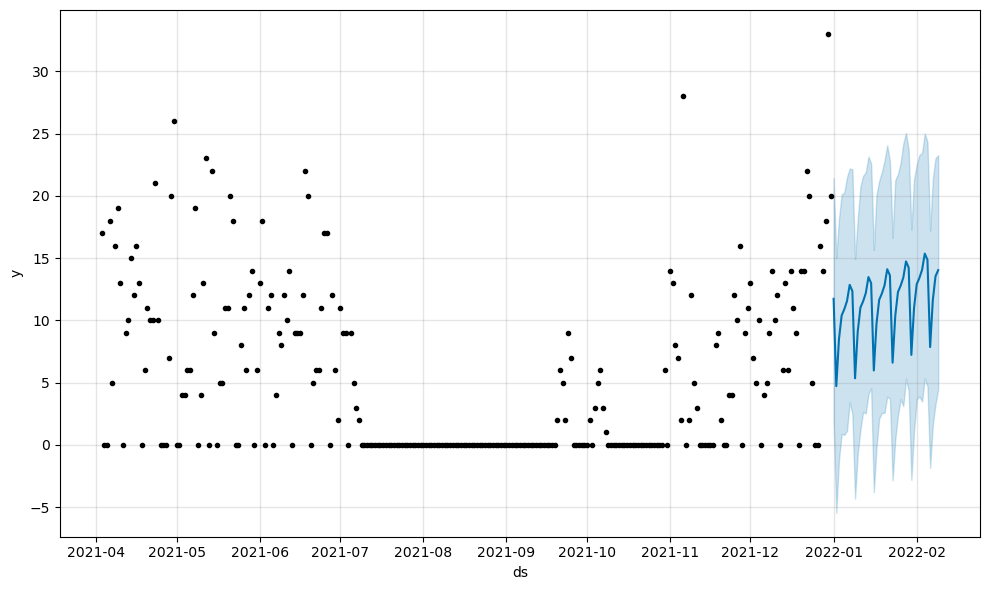

In [100]:
df_predict = df.groupby(['item_number', 'item_name']).apply(train_prophet).reset_index(drop=True)

In [102]:
def get_metrics(df_item):
    return mean_absolute_error(df_item['y'], df_item['yhat'])
metrics =df_predict.groupby(['item_number', 'item_name']).apply(get_metrics)

In [103]:
metrics

item_number  item_name                     
80028349     UH ZWIEBELN DE-HE I 1KG GS        9.329116
80101923     SL MANDARINEN BEH.ES I 750G GS    7.483144
80317483     ROMA TOMATEN ES I 500G SF         4.418792
dtype: float64

MAE: 4.419


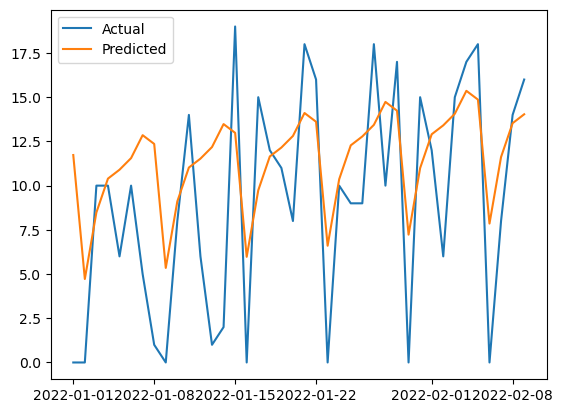

MAE: 7.483


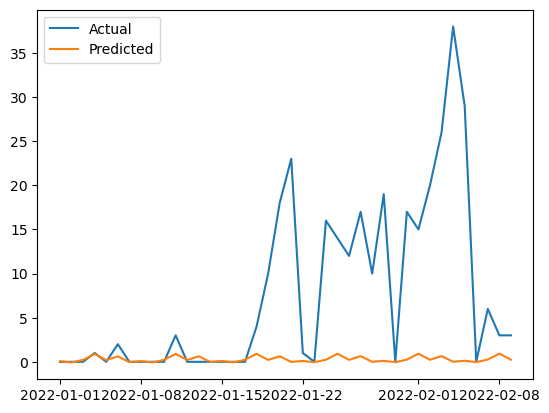

MAE: 9.329


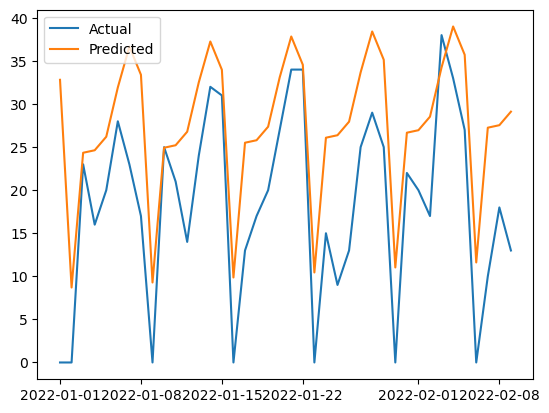

In [107]:
for i in items:
    df_item = df_predict[df_predict['item_number']==i]
    x = df_item['ds'].values
    y_true = df_item['y'].values
    y_pred = df_item['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE: %.3f' % mae)
    # plot expected vs actual
    pyplot.plot(x, y_true, label='Actual')
    pyplot.plot(x, y_pred, label='Predicted')
#     pyplot.plot()
    pyplot.legend()
    pyplot.show()
    

# Experiment 2

In [129]:
exp_date ='2022-02-01'
def train_prophet(df_item):
    df_item = df_item.rename(columns={
        'day':'ds',
        'sales_quantity': 'y'
    })
    
    model = Prophet(interval_width=0.95)
    
    ts_train = (df_item.query(f"ds < '{exp_date}'")
                  .sort_values('ds')
                )

    ts_test = (df_item
               .query(f"ds >= '{exp_date}'")
               .sort_values('ds')
               .assign(ds=lambda x: pd.to_datetime(x["ds"]))
               )
    model.fit(ts_train)

    model.make_future_dataframe()
  
    # at this step we predict the future and we get plenty of additional columns be cautious
    ts_hat = (model.predict(ts_test)[["ds", "yhat", 'yhat_lower', 'yhat_upper']]
              .assign(ds=lambda x: pd.to_datetime(x["ds"]))
              ).merge(ts_test, on=["ds"], how="left")  # merge to retrieve item and store index
    
    model.plot(ts_hat)
 
    return ts_hat

18:40:53 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing
18:40:53 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing
18:40:53 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing


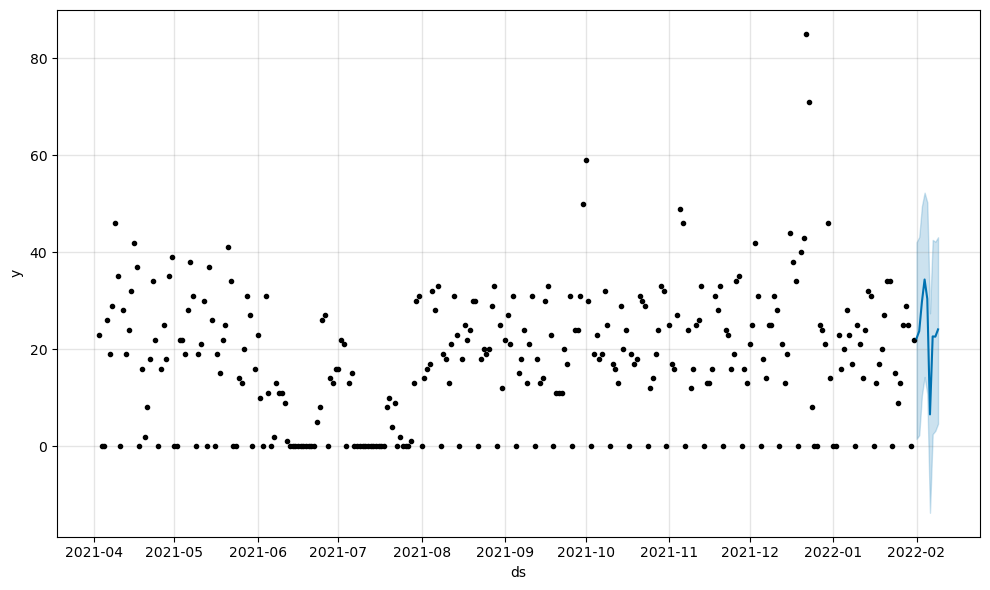

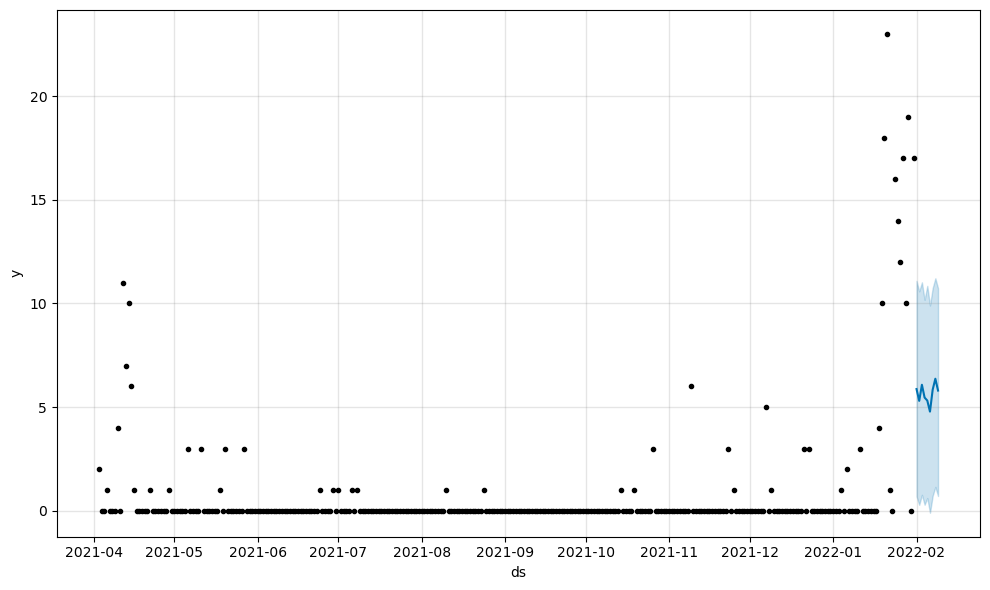

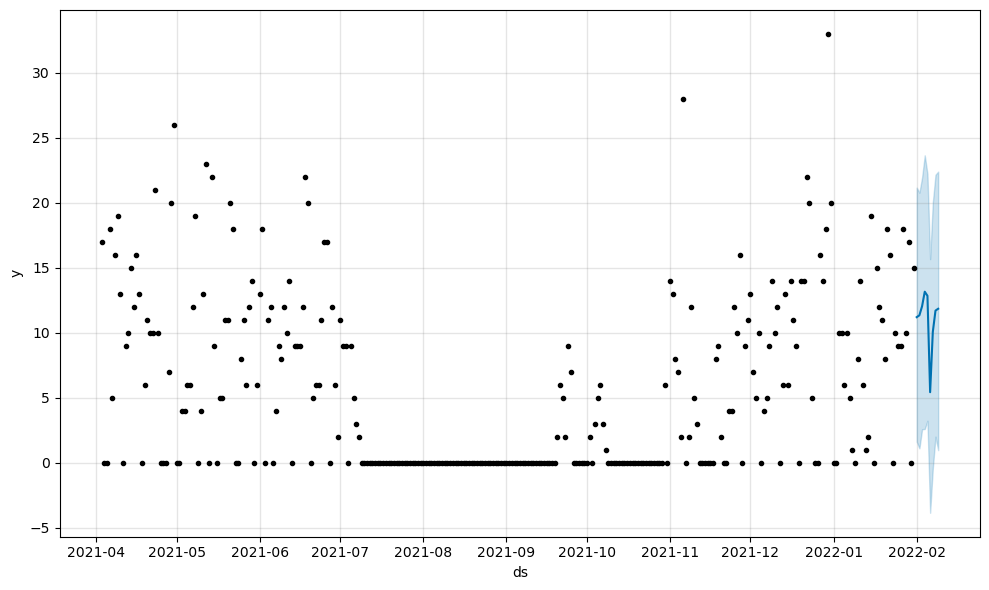

In [130]:
df_predict = df.groupby(['item_number', 'item_name']).apply(train_prophet).reset_index(drop=True)

In [131]:
metrics =df_predict.groupby(['item_number', 'item_name']).apply(get_metrics)
metrics

item_number  item_name                     
80028349     UH ZWIEBELN DE-HE I 1KG GS         6.319279
80101923     SL MANDARINEN BEH.ES I 750G GS    12.341862
80317483     ROMA TOMATEN ES I 500G SF          3.558732
dtype: float64

MAE: 3.559


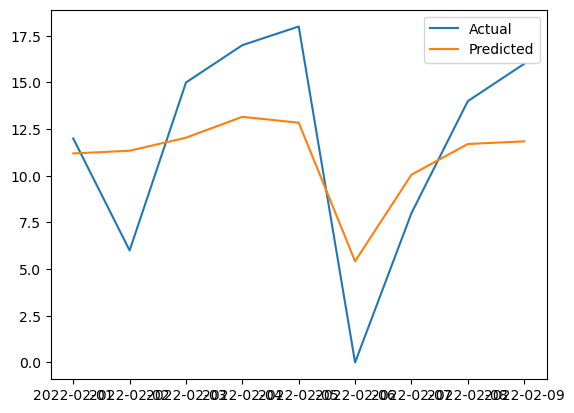

MAE: 12.342


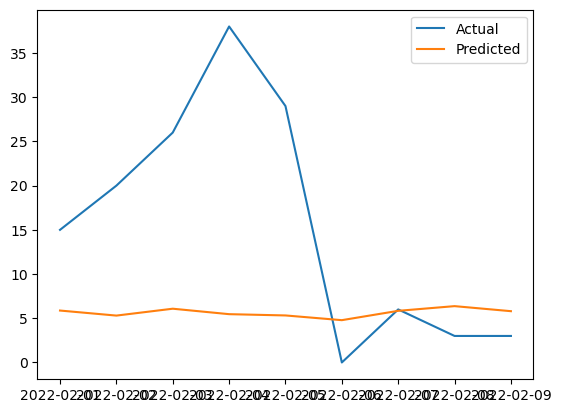

MAE: 6.319


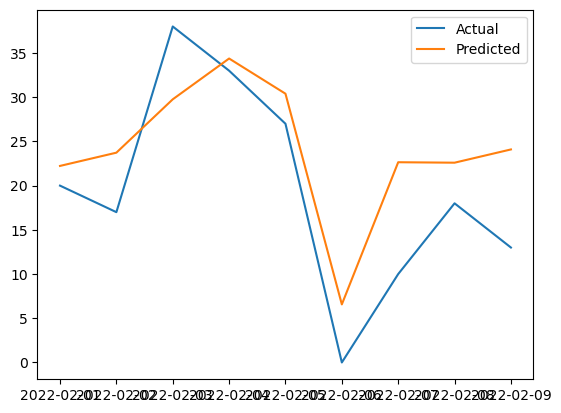

In [132]:
for i in items:
    df_item = df_predict[df_predict['item_number']==i]
    x = df_item['ds'].values
    y_true = df_item['y'].values
    y_pred = df_item['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE: %.3f' % mae)
    # plot expected vs actual
    pyplot.plot(x, y_true, label='Actual')
    pyplot.plot(x, y_pred, label='Predicted')
#     pyplot.plot()
    pyplot.legend()
    pyplot.show()
    

In [135]:
def preprocess(df: pd.DataFrame):
    df = pd.read_csv("data.csv", index_col=0)
    df = df.fillna(0)  # replace nulls with zeros in sales and orders
    df = df.drop_duplicates()
    return df